# <center> Are Haters Just Hating?: A Statistical Analysis of CSGO Pro Gamers
<center> Sam Felsenfeld, Cindy Jia, Mark Levin </center>

## <center> Introduction</center>

Public opinion can often be a misrepresentation of the actual performance of public figures. In this analysis, we explore the case of CSGO e-sports athletes, and determine whether the public perception that a player is either at the top of their game or on their way out actually correlated with their typical performance, or more likely influenced by a single event.

## <center> Data Collection


In [176]:
import datetime
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests
import functools
from bs4 import BeautifulSoup
import re
from requests_html import AsyncHTMLSession
import os
from statsmodels.formula.api import ols

In [5]:
### Create a list of world rankings
url = "https://pro.eslgaming.com/worldranking/csgo/rankingshistory/"

### Get page and render javascript
session = AsyncHTMLSession()
r = await session.get(url)
await r.html.arender()


### Start scraping page (not finished)
bs = BeautifulSoup(r.html.html)
for el in bs.find_all("div", class_="small"):
    print(el)

[INFO] Starting Chromium download.
100%|██████████| 86.8M/86.8M [00:05<00:00, 14.5Mb/s]
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/marklevin/Library/Application Support/pyppeteer/local-chromium/588429


In [60]:
### Scrape all team rankings and put it in a big dictionary ###
if "team_rankings.json" not in os.listdir("."):
    url = "https://cdn1.api.esl.tv/csgo/worldranking/teamhistory/rankings?date="
    rankings_team_date = {}
    # Come up with our date range, starting in 2016 and ending at modern day
    dates = pd.date_range(start="2015-12-28", end="2023-5-8")
    for date in tqdm(dates):
        # make our json query
        r = requests.get(url + date.strftime("%y-%m-%d"))
        try:
            for team in r.json()["items"]:
                try: # append this ranking to our team's dictionary at this date
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
                except: # We need to make a new entry for team
                    rankings_team_date[team["teaminfo"]["name"]] = {}
                    rankings_team_date[team["teaminfo"]["name"]][date.strftime("%y-%m-%d")] = team["power_rank"]
        except: # sometimes a day is not recorded
            ...
    with open("team_rankings.json","w") as f:
        json.dump(rankings_team_date, f)

else:
    print("found team rankings file, reading")
    with open("team_rankings.json",'r') as f:
        rankings_team_date = json.load(f)

found team rankings file, reading


In [6]:
### Get a list of awpers from liquipedia
### Getting awpers
urls = ["https://liquipedia.net/counterstrike/Category:AWPers",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Galantis#mw-pages",
        "https://liquipedia.net/counterstrike/index.php?title=Category:AWPers&pagefrom=Powell#mw-pages"]

if "team_rankings.json" not in os.listdir("."):
    awpers = {"~~~~"} # Create a lookup table of awpers
    for url in urls:
        res = requests.get(url)
        bs = BeautifulSoup(res.content)
        ### Toggle system to only get from first to last player on each page
        toggle = False
        for l in bs.find_all("a"):
            if "Ace" in l.get('href') or "/Galantis" in l.get('href') or "/Powell" in l.get('href'):
                toggle=True
            if toggle:
                # When adding names of awpers to the table, we are extremely loose with what counts
                # adding several variations to make sure that when we lookup names from different data
                # sources we garuntee a match if we should have one.
                s = l.get('href')[15:].lower()
                awpers.add(s) # Add base name
                if "_" in s:
                    s = s[:s.find("_")] # add name with extra annotations removed
                awpers.add(s)
                s = re.sub(r'[^a-zA-Z0-9]', '', s)# Remove extra characters
                awpers.add(s)
            if "Gafolo" in l.get('href') or "Potei" in l.get('href') or "ZywOo" in l.get('href'):
                toggle=False

    # Dump data to a json file for future reference
    with open("awpers.json", 'w') as file:
        json.dump(list(awpers), file)
else:
    with open('awpers.json') as file:
        awpers = json.load(file)

## <center> Data Processing

In [4]:
df = pd.read_csv("all games processed.csv", sep=',')
with open('awpers.json') as file:
    awpers = json.load(file)
df= df.drop('Unnamed: 0', axis=1)

# cleaning data and labeling awpers
df['rating'] = df['rating'].apply(lambda s: float(s.replace("*", "")))
df['Awper'] = df['player name'].apply(lambda s: s in awpers)
df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper
0,31/10/20,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False
1,31/10/20,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False
2,19/5/20,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False
3,19/5/20,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False
4,18/5/20,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False


In [49]:
players = df['player name'].unique()
teams = df['Player team'].unique()

In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= pd.to_datetime('2016'))]
df.sort_values('Date').head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating
709304,2016-01-02,eXplosive,Granted,cbl,8 - 22,-14,0.54,aiyvan,0.363636,9,16,25,True,-1.623296
677070,2016-01-02,Tectonic,ex-Astral Authority,mrg,25 - 19,6,1.44,drone,1.315789,16,13,29,False,0.973433
480809,2016-01-02,Vexed,Torpedo,ovp,25 - 23,2,1.20,hyper,1.086957,14,16,30,False,0.285812
731276,2016-01-02,TheMongolz,Renegades,cbl,17 - 19,-2,0.83,ncl,0.894737,16,9,25,False,-0.774271
731275,2016-01-02,TheMongolz,Renegades,inf,8 - 4,4,1.14,ncl,2.000000,16,2,18,False,0.113906


In [174]:
@functools.lru_cache()
def lookup_team_name(team):
    if team in rankings_team_date:
        return team
    possible = [name for name in rankings_team_date.keys() if bool(re.search(rf'^{re.escape(team)} ', name))]
    if possible:
        return possible[0]
    return None

@functools.lru_cache()
def lookup_team_rank(team, date):
    name = lookup_team_name(team)
    if name:
        team_data = rankings_team_date[name]
        return team_data[min(team_data.keys(), key=lambda x: abs((datetime.datetime.strptime(x, '%y-%m-%d') - date)))]
    return len(rankings_team_date)

def normalize_rating(game):
    if not game.name % 1000:
        print(game.name)
    date = game['Date']
    player_team = lookup_team_rank(game['Player team'], date)
    opp_team = lookup_team_rank(game['Opponent'], date)
    diff = player_team - opp_team
    return game['rating'] * math.sqrt(math.log(abs(diff) + 10, 10)) ** (1 if diff >= 0 else -1)


focus_players = ('zywoo','axle','karrigan','glave','teses','perfecto','smple','cerq')
sub_df = df[(df['player name'].apply(lambda x: x in focus_players))].reset_index()
sub_df['norm'] = sub_df[['Date', 'Player team', 'Opponent', 'rating']].apply(normalize_rating, axis=1)
sub_df.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


,index,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating,norm_rating,Year,norm
0,59541,2022-02-11,Evil Geniuses,Cloud9,ovp,21 - 18,3,1.08,cerq,1.166667,11,16,27,True,-0.759858,0.590331,2022,1.268810
1,59542,2022-02-11,Evil Geniuses,Cloud9,d2,12 - 14,-2,0.81,cerq,0.857143,5,16,21,True,-0.848411,0.442748,2022,0.951607
2,59543,2022-01-11,Evil Geniuses,9z,nuke,17 - 23,-6,0.79,cerq,0.739130,17,19,36,True,-0.782746,0.552186,2022,0.856737
3,59544,2022-01-11,Evil Geniuses,MOUZ,mrg,7 - 15,-8,0.70,cerq,0.466667,10,16,26,True,-0.884488,0.382622,2022,0.822377
4,59545,2022-10-31,Evil Geniuses,IHC,nuke,22 - 14,8,1.25,cerq,1.571429,16,9,25,True,0.501024,2.691728,2022,0.998180


In [161]:
x = np.arange(2012, 2024)
y = []
y_awp = []
y_rifle = []

# determining mean performance per year and standardizing rating
for year in x:
    date_mask = (dt.datetime(year,1,1) < df['Date']) & (df['Date'] < dt.datetime(year,12,31))
    y.append(df[date_mask]['norm_rating'].mean())
    mean_awp = df[date_mask & df['Awper']]['norm_rating'].mean()
    y_awp.append(mean_awp)
    mean_rifle = df[date_mask & ~df['Awper']]['norm_rating'].mean()
    y_rifle.append(mean_rifle)

    std_awp = df[date_mask & df['Awper']]['norm_rating'].std()
    std_rifle = df[date_mask & ~df['Awper']]['norm_rating'].std()
    
    df.loc[date_mask & df['Awper'],'standard rating'] = (df['norm_rating']-mean_awp) / std_awp
    df.loc[date_mask & ~df['Awper'],'standard rating'] = (df['norm_rating']-mean_rifle) / std_rifle

df.head()

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating,norm_rating,Year
0,2020-10-31,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False,-0.576726,0.830000,2020
1,2020-10-31,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False,-0.614214,0.770000,2020
2,2020-05-19,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False,-0.745422,0.560000,2020
3,2020-05-19,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False,-0.714182,0.610000,2020
4,2020-05-18,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False,-0.947368,0.236782,2020


## <center> Data Analysis

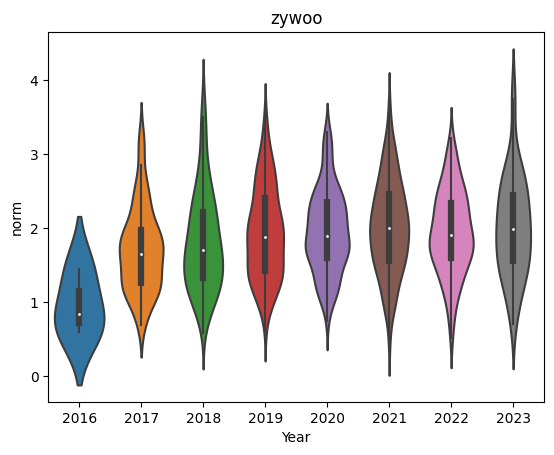

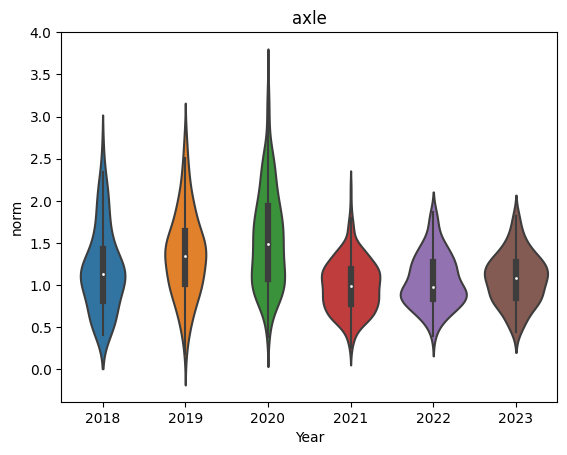

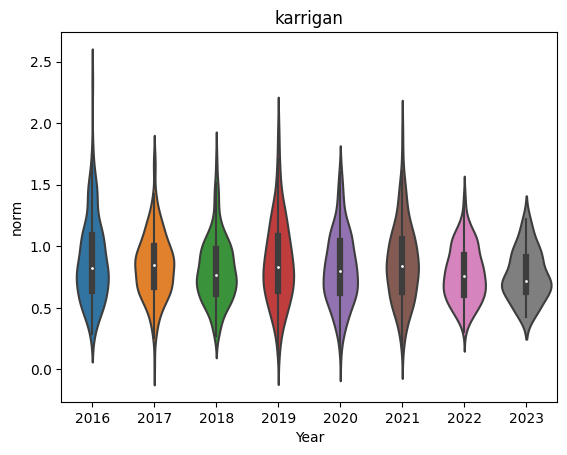

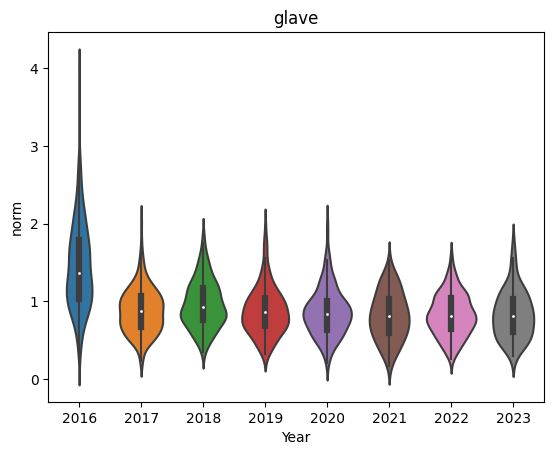

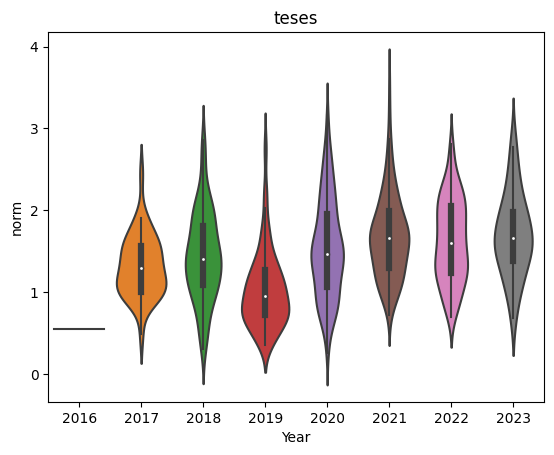

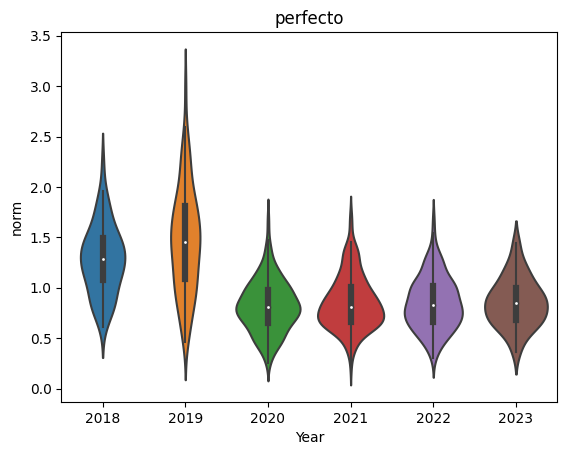

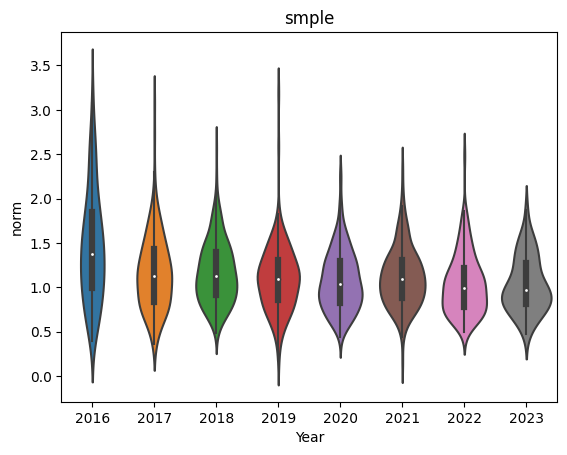

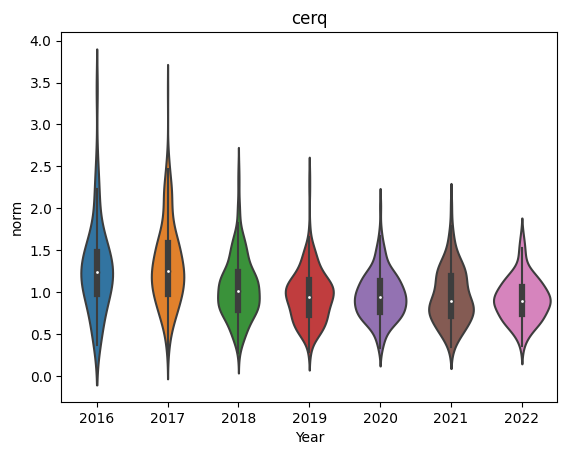

In [175]:
df['Year'] = df['Date'].apply(lambda x: x.year)
for player in focus_players:
    plt.figure()
    sns.violinplot(sub_df[(sub_df['player name'] == player)], x='Year', y='norm')
    plt.title(player)

,Date,Player team,Opponent,Map,kd,pm,rating,player name,kd ratio,rounds won,rounds lost,Total rounds,Awper,standard rating,norm_rating,Year
0,2020-10-31,Golden Knights,Lyngby Vikings,nuke,17 - 21,-4,0.83,fitch,0.809524,13,16,29,False,-0.576726,0.830000,2020
1,2020-10-31,Golden Knights,Lyngby Vikings,mrg,14 - 20,-6,0.77,fitch,0.700000,16,12,28,False,-0.614214,0.770000,2020
2,2020-05-19,Syman,SG.pro,trn,8 - 20,-12,0.56,fitch,0.400000,13,16,29,False,-0.745422,0.560000,2020
3,2020-05-19,Syman,SG.pro,mrg,11 - 18,-7,0.61,fitch,0.611111,10,16,26,False,-0.714182,0.610000,2020
4,2020-05-18,Syman,LDLC,d2,13 - 19,-6,0.87,fitch,0.684211,11,16,27,False,-0.947368,0.236782,2020


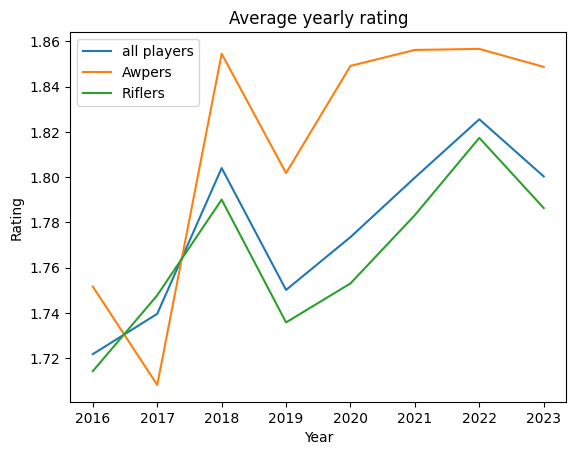

In [142]:
plt.plot(x,y,label = 'all players')
plt.plot(x,y_awp,label = 'Awpers')
plt.plot(x,y_rifle,label = 'Riflers')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Rating")
plt.title("Average yearly rating")
df.head()